# MTGNNe
Daniel Alejandro Alonso Bastos

El objetivo de esta libreta es dar una introducción al problema, exponer las propuestas de modificaciones a la arquitectura **MTGNN** al añadir distintos mecanismos de atención. Además, también se muestra el flujo completo para descargar y cargar los datos, entrenar todas las arquitecturas propuestas y observar los resultados de entrenamiento, y las métricas al evaluar en los conjuntos de validación y prueba.

Como es un notebook que muestra el flujo de punta a punta, no busca realizar entrenamientos muy exhaustivos, es por eso que solo se entrena con 5 épocas cada arquitectura. Los experimentos se realizan en el notebook `2-mtgnne-experiments`

## Introducción

El trabajo [Connecting the Dots: Multivariate Time Series Forecasting with Graph Neuronal Networks](https://paperswithcode.com/paper/connecting-the-dots-multivariate-time-series) propone un *framework* de punta a punta para realizar pronósticos de uno o múltiples pasos de una serie de tiempo multivariante empleando *Graph Neural Networks* (GNN) que permita explotar tanto las dependencias espaciales como las temporales a comparación de los métodos estadísticos o de aprendizaje profundo.

**Las series de tiempo multivariantes puede observarse como un grafo**, donde las variables pueden ser consideradas como los nodos que están interconectadas a través de sus relaciones de dependencia oculta, permitiendo así que cada nodo sea **consciente del contexto de su entorno**, aquí es donde toman relevancia las GNN espacio-temporales (ST-GNN) en donde toman como entrada una serie de tiempo y una estructura de grafos, y tienen como objetivo predecir los valores futuros. Las dependencias espaciales son capturadas por grafos convolucionales (GCN), mientras que las dependencias temporales entre los estados históricos se capturan con RNN o convoluciones 1D. **Sin embargo, las ST-GNN tienen 2 problemas importantes:**

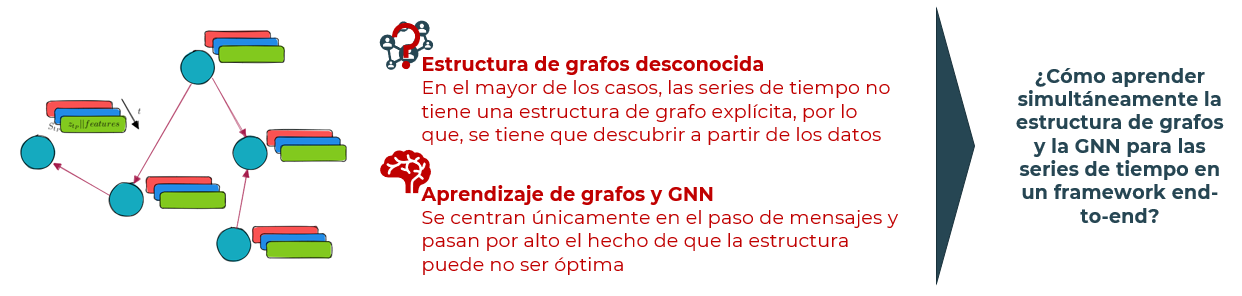

Bajo esas preguntas nace la motivación de los autores de generar un *framework end-to-end* **que sea aplicable para grafos pequeños y grandes, series de tiempo multivariantes cortas y largas, con y sin una estructura del grafo definida**. El *framework* que proponen tiene 3 módulos principales, en los cuáles **se modela la serie de tiempo mientras que simultáneamente aprende la estructura del grafo**, y todo sucede en el mismo entrenamiento, dado que todos los parámetros son aprendidos en el entrenamiento.

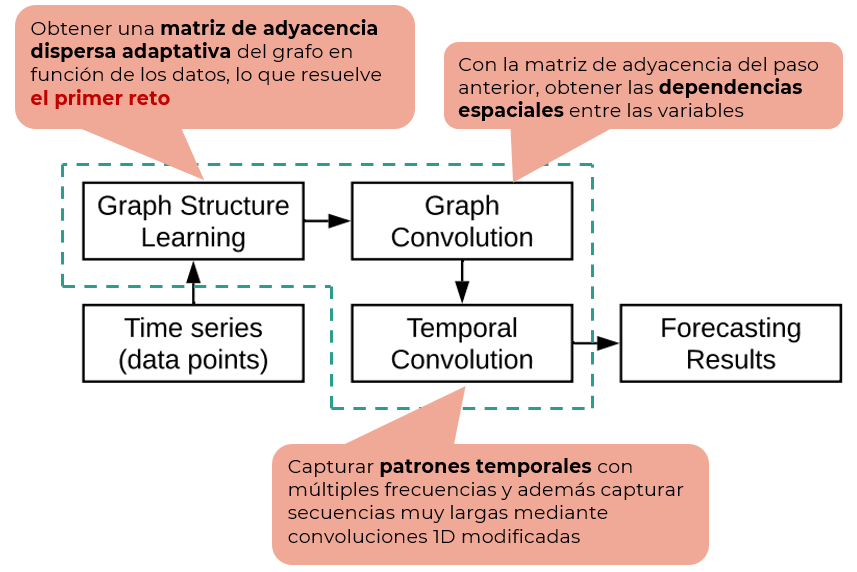

A continuación se describen los 3 módulos

### Graph Learning Layer / Graph Structure Learning

El objetivo de este módulo es aprender la matriz de adyacencia $\mathbf{A}$ adaptativamente para capturar las **relaciones ocultas** entre los datos de la serie temporal.

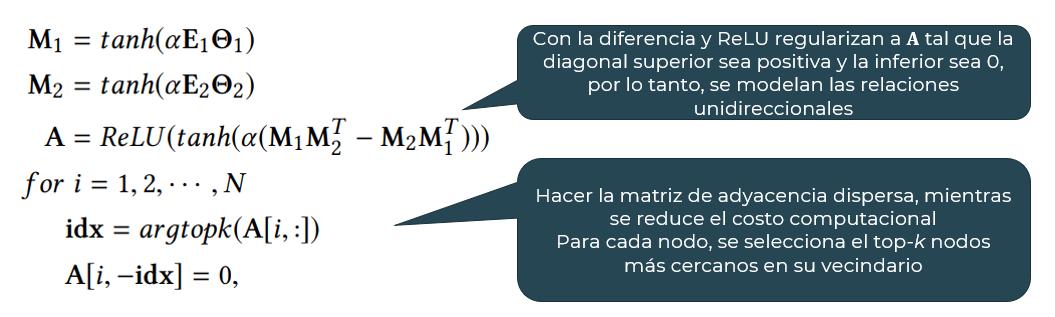

donde $\mathbf{E}_1,\mathbf{E}_2$ representan el *embedding* de nodos inicializados de manera aleatoria y $\mathbf{\Theta}_1,\mathbf{\Theta}_2$ son los parámetros entrenables del modelo, $\alpha$ es un hiperparámetro que controla la saturación de la función de activación $tanh$.

### Graph Convolution Module

Dada la matriz de adyacencia $\mathbf{A}$ calculada en el Graph Learning Layer, el objetivo de este módulo es fusionar la información de un nodo con la de sus vecinos para manejar las dependencias espaciales de un grafo, lo cual lo hace en 2 pasos:
1. Propagación de la información
2. Selección de la información

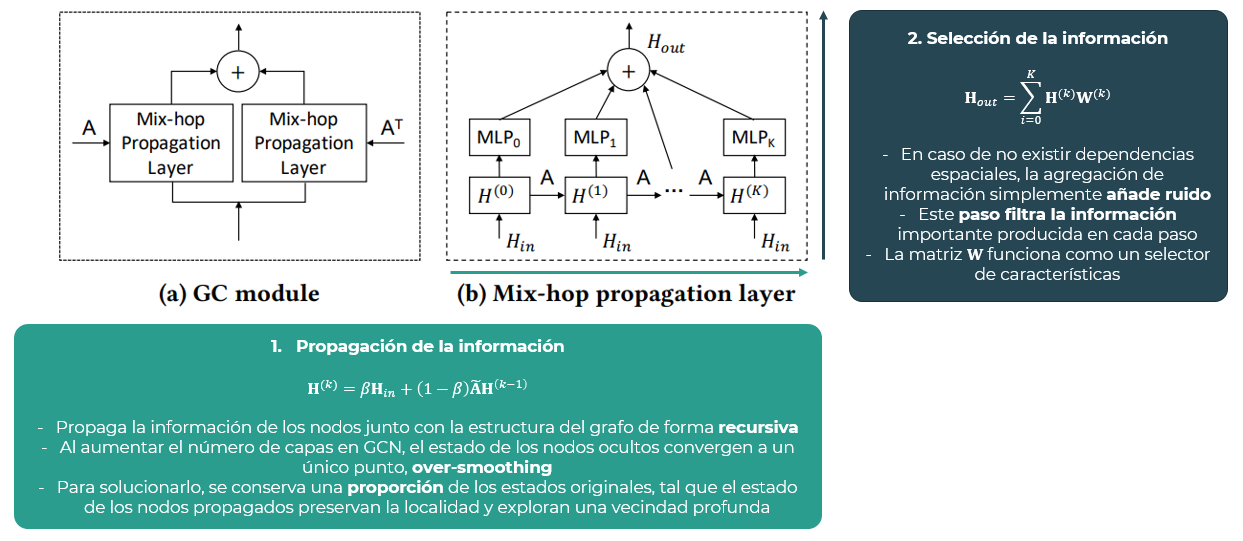

### Temporal Convolution Module

El objetivo de este módulo es extraer características temporales

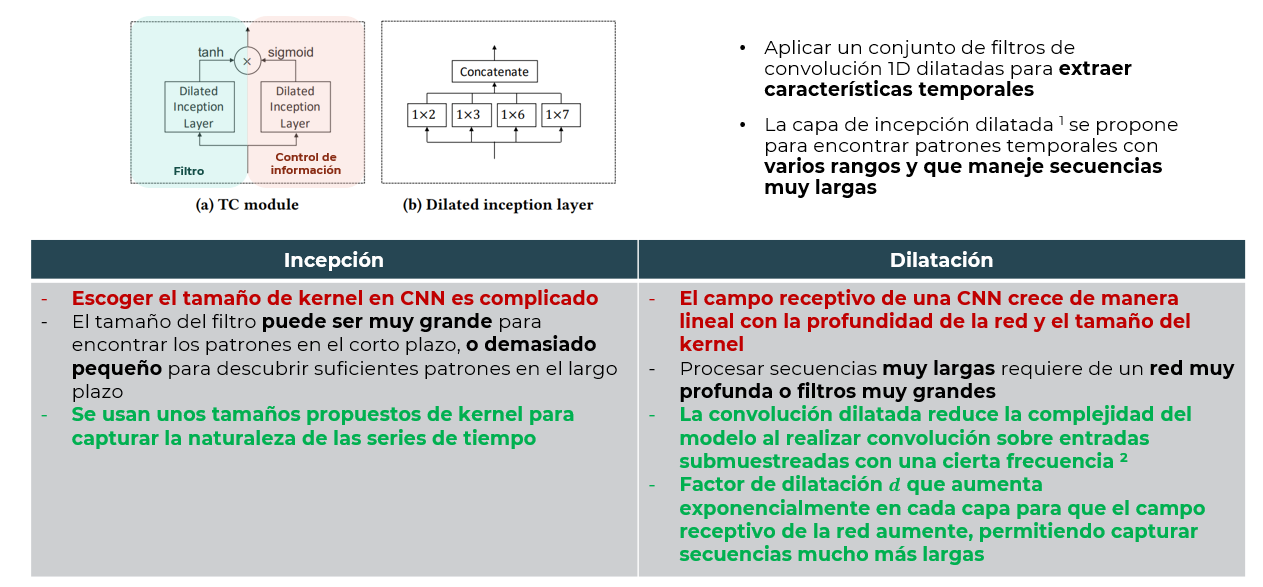

### Arquitectura

Una vez definidos todos los módulos, es momento de describir la arquitectura del modelo MTGNN

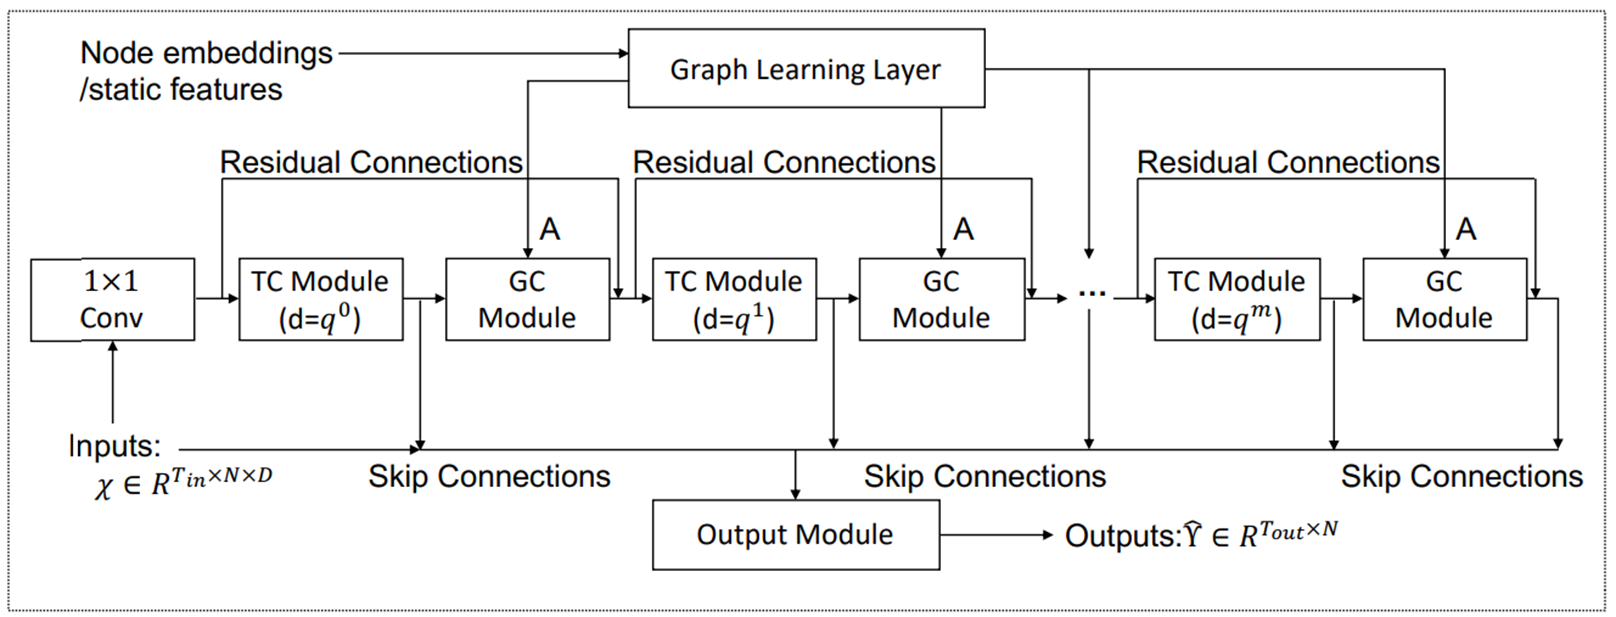

1. La entrada al modelo requiere de un tensor con la siguiente estructura: [B, I, N, W], donde B es el tamaño de lote `batch_size`, I es la dimensión de entrada `in_dim`, N es el número de nodos o variables `num_nodes` y W es el tamaño de la ventana del pasado que se toma `seq_len`.
2. En caso de querer calcular $\mathbf{A}$, el módulo de Graph Learning Layers realiza un *embedding* mapeado a una dimensionalidad `node_dim` con una red totalmente conectada para aprender los parámetros $\mathbf{\Theta}$, realizando las operaciones que se describieron con anterioridad, tal que la salida de este módulo es $\mathbf{A}_{N\times N}$
3. El tensor de entrada se pasa por una convolución 2D con un kernel de $1\times1$ para proyectar la entrada a un espacio latente: [B, RC, N, F] donde RC es el número de canales residuales `residual_channels` y F es el número de características obtenidas
4. La salida de la primera convolución se conectan con las $m$ capas (`layers`) que contienen los módulos de Temporal Convolution (TC) y Graph Convolution (GC) para extraer las dependencias temporales y espaciales respectivamente. Repitiendo los siguientes pasos por el número de capas:
  * Entran las capas Dilated Inception: [B, RC, N, F] -> [B, RC, N, F'], donde F' va disminuyendo dado que el factor de dilatación $d$ controla el tamaño del campo receptivo del módulo TC, que es incrementado por una tasa exponencial $q$. Además se genera otra salida para las conexiones *skip* al realizar una convolución 2D que genera un tensor de dimensiones [B, SC, N, I] donde SC es el número de canales en la conexión *skip* `skip_channels`
  * El tensor [B, RC, N, F'] entra a la capa GC, junto con la matriz $\mathbf{A}$ caLculada por la Graph Learning Layer realiza el paso de propagación de información al calcular $\mathbf{H}^{(k)}=\beta\mathbf{H}_{in}+(1-\beta)\tilde{\mathbf{A}}\mathbf{H}^{(k-1)}$ donde $\beta$ es un hiperparámetro que controla la proporción de conservación de los estados originales (`propbeta`), mientras que $k$ representa la profundidad del grafo convolucional GCN (`gcn_depth`). Una vez obtenidos los estados $\mathbf{H}^{(k)}$, se realiza el paso de selección de información al pasarlo por una red completamente conectada, retornando un tensor con las mismas dimensiones de entrada.
  * Después pasa por una capa de normalización de capa.
5. Las conexiones residuales y *skip* se suman en el modelo para evitar el problema de desvanecimiento de gradiente. Para eso se realizan un par de convoluciones 2D, la primera [B, SC, N, I] -> [B, EC, N, I] donde EC es el número de canales al final `end_channels`, la segunda convolución 2d [B, EC, N, I] -> [B, O, N, I] donde O es el número de dimensiones de salida `out_dim`.



## Propuesta

La propuesta radica en realizar un par de modificaciones en el módulo GC, específicamente en el paso de propagación de la capa Mix-Hop. Dichas modificaciones son:
1. Agregar mecanismos de atención al fusionar la información de un nodo con la de sus vecinos para manejar las dependencias especiales, esto con la idea de que algunos nodos vecinos influyen más que otros. Tal que $\tilde{\mathbf{A}}=\mathbf{\alpha}\tilde{\mathbf{A}}$
donde $\mathbf{\alpha}$ es la importancia de un nodo $v$ con su vecino $u$, i.e., $\alpha_{vu}$. El modelo resultante de esta modificación se llama **MTGAN**
2. Agregar mecanismos de atención al propagar la información en el número de capas que tiene el GCN, tal que:
\begin{equation}
\mathbf{H}^{(k)}=\beta\mathbf{H}_{in}+(1-\beta){\mathbf{\alpha}}\tilde{\mathbf{A}}\mathbf{H}^{(k-1)}
\end{equation}. El modelo resultante se llama **MTGNNAH** o si también emplea los mecanismos de atención descritos en el punto anterior **MTGANAH**

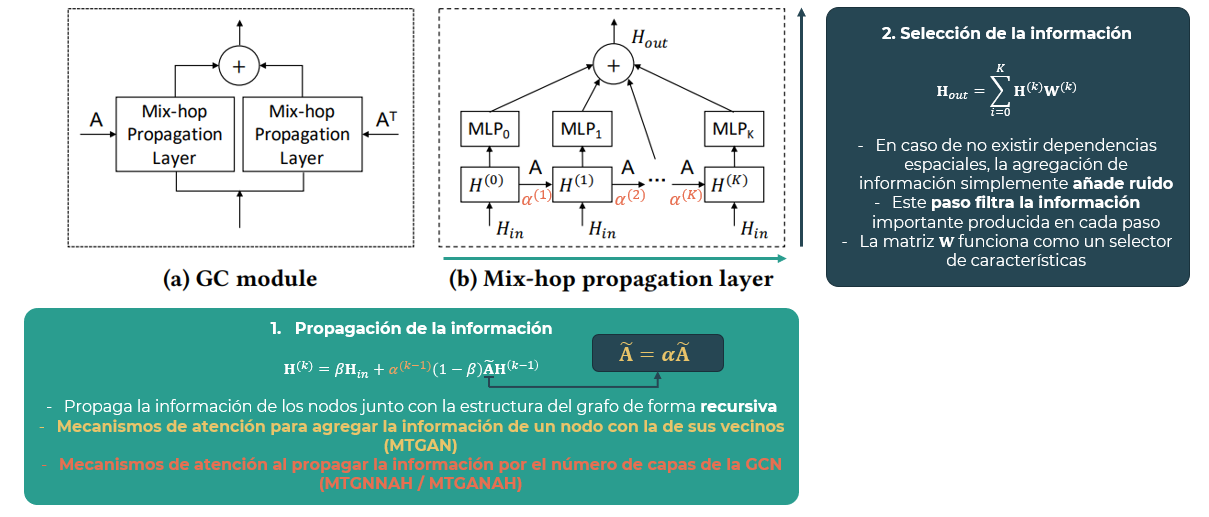

Para probar su *framework* los autores trabajaron sobre 4 benchmark de series de tiempo multivariantes que no tienen una estructura de grafo definida, y con otras 2 que si tienen una estructura de grafo definida. Compararon su algoritmo MTGNN con y sin muestreo contra varios modelos en el estado del arte, dando resultados muy buenos, en la mayoría mejores que en el estado del arte en el caso de las series de tiempo sin una estructura de grafo definida, mientras que en las otras no superan a los modelos en el estado del arte pero se aproximan mucho.

**Para realizar las comparaciones del modelo MTGNN con las modificaciones propuestas, se decidió emplear la base de datos de [exchange-rate](https://github.com/laiguokun/multivariate-time-series-data/tree/master/exchange_rate)** que es una colección del tipo de cambio diario de ocho países: Australia, Gran Bretaña, Canadá, Suiza, China, Japón, Nueva Zelanda y Singapur, desde 1990 hasta 2016. El motivo de seleccionarla es porque tienen menor cantidad de datos, por lo que el tiempo de entrenamiento es menor y así se podrán realizar múltiples ejecuciones. **Además se seleccionó realizar una predicción de una salida con un horizonte de 3 pasos de tiempo.**

Los resultados experimentales constan de obtener el promedio y desviación estándar después de ejecutar 10 veces el modelo.

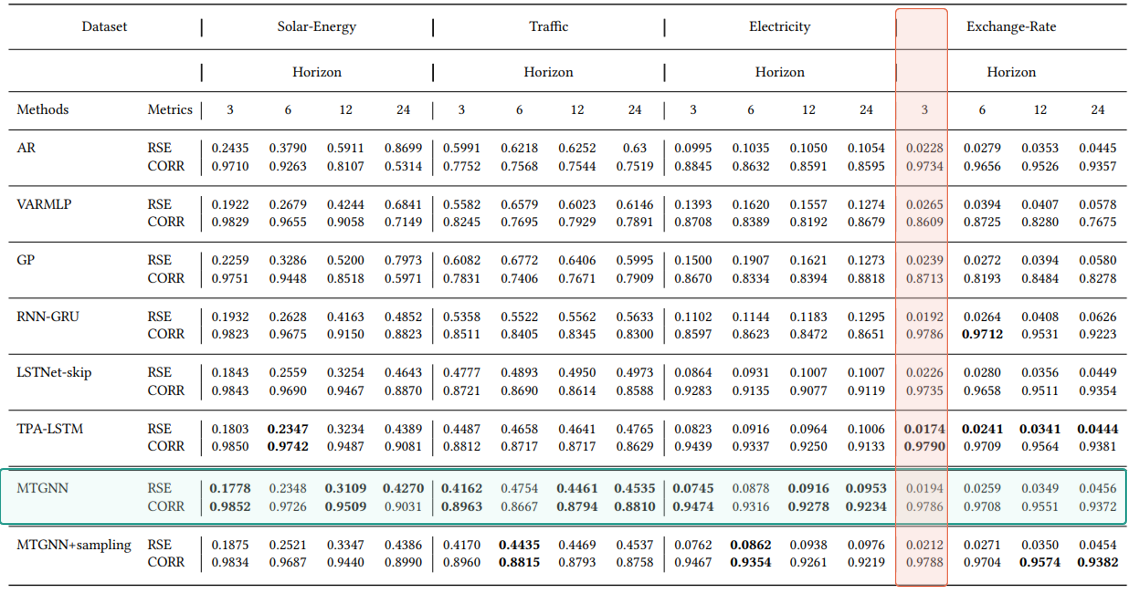

## 1 Preparación

### 1.1 Bibliotecas

Instalación de bibliotecas

In [1]:
#! pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113 
# inspeccionar arquitecturas
#! pip install torchinfo
# barras de progreso
#! pip install tqdm

Nota: Las siguientes librerías son para utilizar [PyTorch Geometric Temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html), que tiene cargado los [modelos](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html) ST-GNN, incluido el de [MTGNN](https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/attention/mtgnn.html#MTGNN), **pero no es necesario instalarlo** dado que todo el proyecto está realizado con PyTorch y el modelo MTGNN se tiene en el archivo `MTGNN.py` en el directorio de este notebook. Además la instalación es tardada y a veces complicada.

In [2]:
#! pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#! pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#! pip install torch-geometric
#! pip install torch-geometric-temporal 

En el directorio del notebook se encuentran 2 archivos .py:
* `MTGNN.py` es donde se encuentra la clase `MTGNN`, que es la implementación original.
* `MTGNNe.py` es donde se encuentra la clase `MTGNNe` que es la extensión al modelo original implementando las 2 modificaciones propuestas, en la cual también se puede obtener el modelo MTGNN modificando el parámetro `arquitecture = MTGNN`

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random

# redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets.utils as tvu

# carga de los modelos (que esta en el mismo directorio que el notebook)
#from MTGNN import MTGNN
from MTGNNe import MTGNNe

# inspección de arquitectura
from torchinfo import summary

# descompresion
import gzip

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

### 1.2 Auxiliares

In [4]:
# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

# descomprimir los archivos txt.gz -> txt
def decompress(infile, tofile):
    with open(infile, 'rb') as inf, open(tofile, 'w', encoding='utf8') as tof:
        decom_str = gzip.decompress(inf.read()).decode('utf-8')
        tof.write(decom_str)

def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

# grafica de perdidas
def display_losses(losses, title='Model loss', plot=True, path2save=None):
    train_loss, test_loss = zip(*losses)
    # eje x (numero enteros [1,epocas])
    x = np.arange(1,len(train_loss)+1, dtype=np.int8)
    plt.figure(figsize=(8, 4))
    plt.plot(x,train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
    plt.plot(x,test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
    #plt.ylim([0,100])
    plt.xticks(x)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid()
    plt.legend()
    # guardar grafica
    if path2save is not None:
        plt.savefig(path2save)
    if not plot: 
        plt.close()
    else:
        plt.show()

# convierte una matriz de adyacencia en un tensor de aristas con sus pesos
# esto es para poder ocupar arquitecturas de torch-geometric
# NOTA: no se utiliza en el proyecto, pero como trabajo a futuro, el modelo MTGNNe puede implementar
# bloques de torch-geometric, para lo que es necesario tener la lista de aristas con sus pesos
def edges_from_adjacency(A):
    '''
    Funcion para obtener la lista de aristas y sus pesos en formato de pytorch geomtric
    A: matriz de adyacencia
    '''
    # obtener la lista de indices
    edge_index = A.nonzero().t().contiguous()
    # obtener los pesos
    n_connections = edge_index.shape[1] # numero de conexiones
    edge_weight = torch.zeros(n_connections) # inicializar tensor de pesos
    # iterar en cada conexion
    for edge in range(n_connections):
        row = edge_index[0,edge].item() # nodo origen
        column = edge_index[1,edge].item() # nodo destino
        # obtencion del peso de la matriz de adyacencia A
        weight = A[row, column].item()
        # actualizacion en el tensor de pesos
        edge_weight[edge] = weight
    
    return edge_index, edge_weight

### 1.3 Parámetros

A continuación se asignan los parámetros para ejecutar el código dividos en los parámetros para el cargador de datos, de entrenamiento, de instancia del modelo y de impresión de resultados.

Para realizar las comparaciones, los parámetros del modelo se mantienen como los utilizados en el [repositorio](https://github.com/nnzhan/MTGNN) del artículo.

In [5]:
# CARGADOR DE DATOS
root='../data' # directorio para guardar los datos
dataset = 'exchange_rate' # dataset a analizar (electricity, exchange_rate, solar-energy, traffic)
train_ratio = 0.6 # proporcion del conjunto de entrenamiento
valid_ratio = 0.2 # proporcion del conjunto de evaluacion
horizon = 3 # numero de pasos a realizar la prediccion
normalize = 2 # tipo de normalizacion en el DataLoaderS2
batch_size = 4 # tamanio de lote

# ENTRENAMIENTO
epochs = 5 # numero de epocas de entrenamiento
lr = 1e-4 # learning rate
opt = 'Adam' # optimizador (SGD, RMSProp, Adam, Adagrad, Adadelta)
weight_decay = 1e-5 # factor de penalizacion
L1Loss = True # tipo de perdida (L1Loss o MSELoss (False))
step_size = 100 # impresion de resultados en el paso step_size
num_split = 1
clip = 5
save_path_model = './model-exchange-3.pt' # ruta para guardar el modelo final

# MODELO
## GENERAL
gcn_true = True # agregar capa de graph convolution (MixProp)
build_adj = True # construir la matriz de adyacencia A (Graph Learning Layer)
dropout = 0.3
kernel_size = 7 # (auxiliar para el calculo del campo receptivo)
window = 24*7 # ventana de tiempo hacia atras (lags)
arquitecture = 'MTGNN' # MTGNN, MTGAN, MTGNNAH, MTGANAH
## connections
conv_channels = 16 # numero de canales en el gcn
residual_channels = 16 # numero de canales en las residuales (entrada a cada capa mtgnn)
skip_channels = 32 # numero de canales de las conexiones skip
## MixProp
gcn_depth = 2 # profundidad de la gcn (no debe ser grande -> over-smoothing)
propbeta = 0.05 # controla la proporcion de retencion del estado original
### GraphAttentionLayer
n_heads = 16 # numero de cabezas
concat = True # si se concatena en la salida de las cabezas o se toma el promedio (False)
## DilatedInception
kernel_set = [2,3,6,7] # lista de kernels que se ocupan en la capa Dilated inception
dilation_exponential = 2 # dilatacion exponencial (controla el tamanio del campo receptivo)
## GraphConstructor
# num_nodes -> el numero de nodos se calcula en el DataLoaderS2 (# de variables)
subgraph_size = 8 # tamanio del subgrafo -> topk(subgraph_size)
node_dim = 40 # dimension del embedding de los nodos
tanhalpha = 3 # tasa de saturacion de tanh
xd = None
## MTGNNLayer
layers = 5 # numero de capas mtgnn (TC & GC)
layer_norm_affline = False # hacer afin a los elementos en la normalizacion de capas
## MTGNNe
in_dim = 1 # canales de entrada para la convolucion inicial
end_channels = 64 # numero de canales en el modulo de salida
out_dim = 1 # canales de salida en la convolucion final

# VERBOSE
progress_train = True # observar la barra de progreso del entrenamiento
verbose_train = True # imprimir resultados de entrenamiento
verbose_train_epoch = False # mostrar la perdida de entrenamiento y validacion por epoca
verbose_summary = True # imprimir el numero de parametros del modelo
verbose_evaluation = True # imprimir las metricas en el conjunto de prueba
verbose_download = True # imprimir mensajes en la descarga de los datos
plot_losses = True # graficar las perdidas al terminar el entrenamiento
save_path_plot = None # save plot of train and valida losses

## 2 Datos

En esta sección se describen el pipeline de los datos, partiendo de la descarga y la implementación del DataLoader

### 2.1 Descarga de datos

Para la descarga de datos se implementó la clase `TSDatasets`, que toma como entrada la carpeta a guardar los datos `root`, el dataset que se quiere [descargar](https://github.com/laiguokun/multivariate-time-series-data):
* [Electricity consumption](https://github.com/laiguokun/multivariate-time-series-data/tree/master/electricity)
* [Traffic Ussage](https://github.com/laiguokun/multivariate-time-series-data/tree/master/traffic)
* [Solar Energy](https://github.com/laiguokun/multivariate-time-series-data/tree/master/solar-energy)
* [Exchange Rate](https://github.com/laiguokun/multivariate-time-series-data/tree/master/exchange_rate)

Dentro de la clase se descarga y se descomprimen los datos en la carpeta `root`, en caso de que ya existan los datos en la carpeta, solo se mostrará un mensaje diciendo que ya se tienen los datos si se tiene activado el despliegue de mensaje `verbose_download = True`

**Nota: En la clase solo se pueden descargar los benchmark de las series de tiempo que no tienen una estructura de grafo definida**

In [6]:
class TSDatasets():
    '''Descarga y descompresion de los datos de series de tiempo'''
    def __init__(self, root='../data', dataset='electricity', verbose_download=True):
        self.root = root # carpeta root para descargar los archivos
        # diccionario con los distintos datos de series de tiempo
        self.filenames = {
            'electricity': 'electricity.txt.gz',
            'exchange_rate': 'exchange_rate.txt.gz',
            'solar-energy': 'solar_AL.txt.gz',
            'traffic': 'traffic.txt.gz'
        }
        # diccionario con las URLs de descarga para cada conjunto de datos
        self.URLS = {
            'electricity': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/electricity/electricity.txt.gz?raw=true',
            'exchange_rate': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/exchange_rate/exchange_rate.txt.gz?raw=true',
            'solar-energy': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/solar-energy/solar_AL.txt.gz?raw=true',
            'traffic': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/traffic/traffic.txt.gz?raw=true'
        }
        self.filename = self.filenames[dataset] # nombre del archivo .txt.gz
        # path para guardar el archivo txt.gz del conjunto deseado
        self.data_dir = os.path.join(root, self.filename)
        self.URL = self.URLS[dataset] # URL de descarga del conjunto deseado
        # path del archivo txt para descomprimir la informacion
        self.file_txt = os.path.join(root, dataset + '.txt')
        # crear carpeta root (en caso de no existir)
        self.create_root()
        # descargar y descomprimir los datos
        self.download(verbose_download)
    
    # checar si ya se tienen los archivos descargados
    def _check_integrity_download(self):
        return os.path.isfile(self.data_dir)
    
    # checar si ya se tienen los archivos descomprimidos
    def _check_integrity_extract(self):
        return os.path.isfile(self.file_txt)
    
    # crear carpeta root en caso de no existir
    def create_root(self):
        if not os.path.isdir(self.root):
            os.makedirs(self.root)

    def _extract(self,root, filename):
        # crear archivo txt de escritura si no existe
        if not os.path.isfile(self.file_txt):
            f = open(self.file_txt, "x")

        # extraer
        decompress(self.data_dir, self.file_txt)

    def download(self, verbose):
        # revisar si los archivos estan descargados y descomprimidos
        if self._check_integrity_download():
            if verbose: print('Files already downloaded')
            if self._check_integrity_extract():
                if verbose: print('Files already decompressed')
                return

        # descarga
        tvu.download_url(
            url=self.URL,
            root=self.root,
            filename=self.filename
        )
        # extraccion
        self._extract(self.root, self.filename)

In [7]:
# descarga y descompresion del conjunto de datos deseado
ds = TSDatasets(dataset=dataset)
# path a al conjunto de datos txt
ds_data_dir = ds.file_txt
print(ds_data_dir)

Files already downloaded
Files already decompressed
../data\exchange_rate.txt


### 2.2 Cargador de datos

A continuación se describe el DataLoader empleado, que es una modificación al original [`DataLoaderS`](https://github.com/nnzhan/MTGNN/blob/f811746fa7022ebf336f9ecd2434af5f365ecbf6/util.py#L12). El `DataLoaderS2` implementan dichas modificaciones que principalmente radican en hacerlo un poco más transparente en las operaciones que realiza y en obtener el número de nodos que es el número de variables de manera directa:

1. Leer el archivo de los datos y separa el txt por comas
2. Obtener el número de tuplas y atributos, donde los atributos se modelan como nodos `num_nodes`
3. Normalizar los datos según el tipo de normalización `normalize`
4. Separar el conjunto en 3 subconjuntos: entrenamiento (`train_ratio`), validación (`valid_ratio`) y prueba (`1-train_ratio-valid_ratio`), considerando el tamaño de la ventana y horizonte
5. Obtener los datos en función del tamaño de la ventana y horizonte

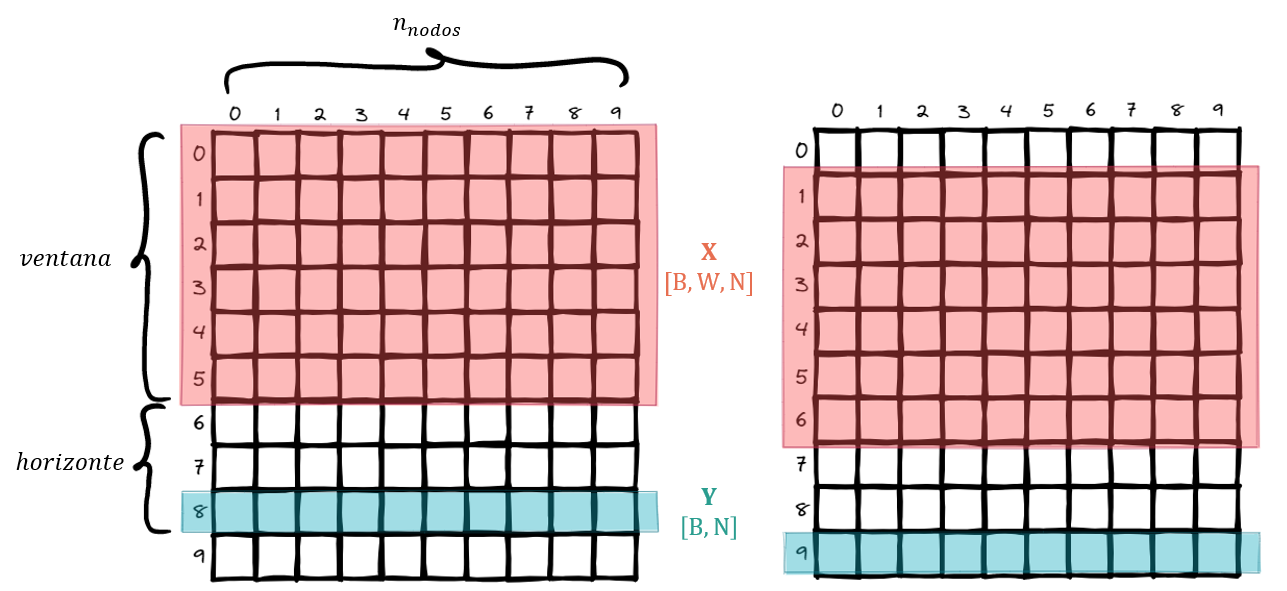

La instancia del `DataLoaderS2` genera un tensor $\mathbf{X}$ con dimensiones [R, W, N] donde R es el número de tuplas en el conjunto, W es el tamaño de la ventana y N es el número de nodos, y también genera un tensor $\mathbf{Y}$ con dimensiones [R, N], para cada uno de los conjuntos. P.ej., `X = data.train[0]` obtiene el tensor $\mathbf{X}$ del conjunto entrenamiento.

El método `get_batches` es análogo al método `__getitem__`, regresa un tensor $\mathbf{X}$ con dimensiones [B, W, N] donde B es el tamaño de lote y un tensor $\mathbf{Y}$ con dimensiones [B, N]. En el entrenamiento el tensor $\mathbf{X}$ es transformado para tener las dimensiones de entrada requerida por el modelo MTGNNe, que es [B, 1, N, W].

Nota: El `DataLoaderS2` únicamente trabaja para realizar pronósticos *single-step*, i.e., realizar la predicción de **un punto hacia adelante**, definido como horizonte.

In [8]:
class DataLoaderS2(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train_ratio, valid_ratio, device, horizon, window, normalize=2):
        self.window = window # ventana del tiempo del pasado a usar
        self.horizon = horizon # numero de pasos a realizar la prediccion
        fin = open(file_name) # abrir el archivo
        self.rawdat = np.loadtxt(fin, delimiter=',') # separar txt por comas
        self.dat = np.zeros(self.rawdat.shape) # inicializar del tamanio de rawdata (filas, columnas)
        self.rows, self.attrs = self.dat.shape # rows -> tuplas, attrs -> variables -> num de nodos
        self.num_nodes = self.attrs # los nodos son las variables
        self.normalize = 2 # tipo de normalizacion
        self.scale = np.ones(self.attrs) # de tamanio del numero de nodos (atributos)
        self._normalized(normalize)
        # separar el conjunto en diferentes conjuntos: entrenamiento, validacion, y prueba
        self._split(int(train_ratio * self.rows), int((train_ratio + valid_ratio) * self.rows), self.rows)

        self.scale = torch.from_numpy(self.scale).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.attrs)

        self.scale = self.scale.to(device)
        self.scale = Variable(self.scale)

        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

        self.device = device

    def _normalized(self, normalize):
        # normalized by the maximum value of entire matrix.

        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat)

        # normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.attrs):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

    def _split(self, train_size, valid_size, test_size):
        # generar los rangos para cada conjunto 
        train_range = range(self.window + self.horizon - 1, train_size)
        valid_range = range(train_size, valid_size)
        test_range = range(valid_size, test_size)
        # generar los tensores X, Y para cada conjunto
        self.train = self._batchify(train_range, self.horizon)
        self.valid = self._batchify(valid_range, self.horizon)
        self.test = self._batchify(test_range, self.horizon)

    def _batchify(self, set_range, horizon):
        # set_range -> es el rango del conjunto (entrenamiento, prueba o valid)
        # generar tensores X, Y
        n_set = len(set_range) # tamanio del rango del conjunto
        # inicializar tensores
        # [R,W,N]
        # R -> filas (tuplas), W -> ventana de tiempo, N -> nodos
        X = torch.zeros((n_set, self.window, self.attrs)) 
        # [R,N]
        Y = torch.zeros((n_set, self.attrs))
        # llenar los tensores al recorrer la ventana de tiempo y horizonte
        for i in range(n_set):
            end = set_range[i] - self.horizon + 1 # idx de inicio de la ventana de tiempo
            start = end - self.window # idx de fin de la ventana de tiempo
            # colocar valores de la ventana en X
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            # colocar valor de ventana + horizonte como Y
            Y[i, :] = torch.from_numpy(self.dat[set_range[i], :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.to(self.device)
            Y = Y.to(self.device)
            yield Variable(X), Variable(Y)
            start_idx += batch_size

In [9]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
# generamos el dataloader
data = DataLoaderS2(file_name=ds_data_dir, train_ratio=train_ratio, valid_ratio=valid_ratio, 
                    device=device, horizon=horizon, window=window, normalize=normalize)

## 3 Modelo

En esta sección se instancian las distintas arquitecturas:
* **MTGNN** es la arquitectura original propuesta en el artículo.
* **MTGAN** es la arquitectura que implementa mecanismos de atención al agregar la información de un nodo con sus vecinos.
* **MTGNNAH** es la arquitectura **MTGNN** con mecanismos de atención al propagar la información en el número de capas de la GCN.
* **MTGANAH** es la arquitectura **MTGAN** con mecanismos de atención al propagar la información en el número de capas de la GCN.

Dentro de la clase `MTGNNe` del archivo `MTGNNe.py` se puede obtener cada arquitectura al variar el parámetro `arquitecture`. Los parámetros del modelo `MTGNN` se mantienen en la clase `MTGNNe` con 3 parámetros adicionales que son `arquitecture`, `n_heads`, `concat`. A continuación se desriben los paraémtros de `MTGNNe`:

* `gcn_true` (bool): Whether to add graph convolution layer.
* `build_adj` (bool): Whether to construct adaptive adjacency matrix.
* `gcn_depth` (int): Graph convolution depth.
* `num_nodes` (int): Number of nodes in the graph.
* `kernel_set` (list of int): List of kernel sizes.
* `kernel_size` (int): Size of kernel for convolution, to calculate receptive field size.
* `dropout` (float): Droupout rate.
* `subgraph_size` (int): Size of subgraph.
* `node_dim` (int): Dimension of nodes.
* `dilation_exponential` (int): Dilation exponential.
* `conv_channels` (int): Convolution channels.
* `residual_channels` (int): Residual channels.
* `skip_channels` (int): Skip channels.
* `end_channels` (int): End channels.
* `seq_length` (int): Length of input sequence (window).
* `in_dim` (int): Input dimension.
* `out_dim` (int): Output dimension.
* `layers` (int): Number of layers.
* `propbeta` (float): Prop beta, ratio of retaining the root nodes's original states in mix-hop propagation, a value between 0 and 1.
* `tanhalpha` (float): Tanh alpha for generating adjacency matrix, alpha controls the saturation rate.
* `layer_norm_affline` (bool): Whether to do elementwise affine in Layer Normalization.
* `xd` (int, optional): Static feature dimension, default None.
* `arquitecture` (str): Type of arquitecture to use ('MTGNN'->original, 'MTGAN'->attention in adj_matrix, 'MTGNNAH'->MTGNN with attention in hops,'MTGANAH'->MTGAN with attention in hops)
* `n_heads` (int): Number of attention heads, in case to use MTGAN or MTGANAH
* `concat` (bool): Whether the multi-head results should be concatenated or averaged, in case to use MTGAN or MTGANAH

El número de nodos se obtiene directamente del `DataLoaderS2`, que es el número de variables en la base de datos

In [11]:
num_nodes = data.num_nodes # ya se obtiene directo del DataLoaderS
print(f'number of nodes: {num_nodes}')

number of nodes: 8


### 3.1 MTGNN

En esta sección se realiza una instancia del modelo MTGNN que servirá como base para validar el funcionamiento de las arquitecturas propuestas.

In [12]:
arquitecture = 'MTGNN'
MTGNN = MTGNNe(gcn_true, build_adj, gcn_depth, num_nodes, kernel_set, kernel_size,
              dropout, subgraph_size, node_dim, dilation_exponential,
              conv_channels, residual_channels, skip_channels, end_channels,
              window, in_dim, out_dim, layers, propbeta, tanhalpha,
              layer_norm_affline, arquitecture, n_heads, concat, xd)

A continuación se realiza una prueba de la arquitectura, el modelo toma como entrada un tensor de dimensiones [B, 1, N, W] y genera una salida de dimensiones [B, 1, N, 1]

In [13]:
# [B, 1, N, W] -> [B, 1, N, 1]
# B -> batch, N -> nodos, W -> ventana de tiempo (lags)
test_tensor = torch.zeros(4, 1, 8, 168)
MTGNN(test_tensor).shape

torch.Size([4, 1, 8, 1])

In [14]:
summary(MTGNN, (4, 1, 8, 168), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MTGNNe                                   [4, 1, 8, 1]              --
├─GraphConstructor: 1-1                  [8, 8]                    --
│    └─Embedding: 2-1                    [8, 40]                   320
│    └─Embedding: 2-2                    [8, 40]                   320
│    └─Linear: 2-3                       [8, 40]                   1,640
│    └─Linear: 2-4                       [8, 40]                   1,640
├─Conv2d: 1-2                            [4, 16, 8, 187]           32
├─Conv2d: 1-3                            [4, 32, 8, 1]             6,016
├─ModuleList: 1-4                        --                        --
│    └─MTGNNLayer: 2-5                   [4, 16, 8, 181]           272
│    │    └─DilatedInception: 3-1        [4, 16, 8, 181]           1,168
│    │    └─DilatedInception: 3-2        [4, 16, 8, 181]           1,168
│    │    └─Conv2d: 3-3                  [4, 32, 8, 1]             

In [15]:
# mover modelo a cpu/gpu
MTGNN = MTGNN.to(device)

### 3.2 MTGAN

La propuesta de MTGAN radica en implementar mecanismos de atención cuando un nodo agrega información en sus vecinos, dicha modificación puntualmente se realiza en la capa Mix-hop que está implementada en la clase `MixProp` en el archivo `MTGNN.py`. Dentro de las GNN, se tiene una variante con de atención como en los transformers, dicha atención se utiliza cuando un nodo agrega información de sus vecinos, pero ahora dando mayor importancia a ciertos vecinos que a otros, dicha variante son las Graph Attention Networks (GAT).

Una GAT se compone de mútliples capas graph attention layers, para ello se realizó la clase `GraphAttentionLayer`, que es una adecuación del paper [Graph Attention Layers](https://nn.labml.ai/graphs/gat/index.html).

La capa toma como entrada un tensor $\mathbf{X}$ con dimensiones [B, F, N, W] donde F es el número de features. Después se realiza una primera transformación lineal al pasarla por una red completamente conectada que mapea al número de salidas de los nodos $F'$ `out_features`, para cada cabeza $k$:

\begin{equation}
\vec{g_i^k}=\mathbf{W}^k\vec{x_i}
\end{equation}

donde $\vec{x_i}\in \mathbb{R}^F$, $F$ siendo el número de features por nodo `in_feature`, que en este caso el número de canales de entrada. Después de realizar la transformación, se reordena se separa el tensor por cada cabeza, obteniendo un tensor de dimensiones [B, W, N, H, F], donde H es el número de cabezas `n_heads`.

Posteriormente se calcula la coeficientes de atención para cada cabeza $k$ ($e_{ij}^k$), que por simplicidad se omite en las siguientes ecuaciones:

\begin{equation}
e_{ij} = \alpha\left ( \mathbf{W}\vec{x_i}, \mathbf{W}\vec{x_j} \right ) = \alpha\left ( \vec{g_i}, \vec{g_j} \right )
\end{equation}

donde $e_{ij}$ representa la importancia del nodo $j$ al nodo $i$, y $\alpha$ es el mecanismo de atención. En el paper se concatenan $\vec{g_i}, \vec{g_j}$ y se realiza una transformación lineal con un vector ponderado $\mathbf{a} \in \mathbb{R}^{2F'}$, seguida de una función de activación LeakyReLU.

\begin{equation}
e_{ij} = \mathrm{LeakyReLU}\left ( \mathbf{a}^\mathrm{T}\left [\vec{g_i} || \vec{g_j}  \right ] \right )
\end{equation}

Empleando la matriz de adyacencia $\mathbf{A}_{N\times N \times H}$, $e_{ij}=-\infty$ si no existe una arista que conecte a los nodos $i,j$. Después se normalizan los coeficientes de atención:

\begin{equation}
\alpha_{ij} = \mathrm{softmax}_j(e_{ij})=\frac{\exp(e_{ij})}{\sum_{k\in N_i}\exp(e_{ik})}
\end{equation}

donde $N_i$ es el vecindario del $i$-ésimo nodo. $e_{ij}=-\infty \rightarrow \exp(e_{ij})\sim 0$ para nodos no conectados.

La salida final para cada cabeza se expresa como:

\begin{equation}
\vec{h_i^{'k}}=\sum_{j\in N_i}\alpha_{ij}^k\vec{g_j^k}
\end{equation}

Para agrupar la salida de las cabezas, se puede concatenar `concatenate = True` o promediar `concatenate = False`

La clase `GraphAttentionLayer` junto con las modificaciones a la clase `MixProp` se encuentran en el archivo `MTGNNe.py`

In [16]:
# instancia de la arquitectura
arquitecture = 'MTGAN'
MTGAN = MTGNNe(gcn_true, build_adj, gcn_depth, num_nodes, kernel_set, kernel_size,
              dropout, subgraph_size, node_dim, dilation_exponential,
              conv_channels, residual_channels, skip_channels, end_channels,
              window, in_dim, out_dim, layers, propbeta, tanhalpha,
              layer_norm_affline, arquitecture, n_heads, concat, xd)

Prueba de la arquitectura

In [17]:
# [B, 1, N, W] -> [B, 1, N, 1]
# B -> batch, N -> nodos, W -> ventana de tiempo (lags)
MTGAN(test_tensor).shape

torch.Size([4, 1, 8, 1])

In [18]:
# mover modelo a cpu/gpu
MTGAN = MTGAN.to(device)

### 3.3 MTGNNAH / MTGANAH

La segunda modificación es emplear mecanismos de atención pero a la transmisión de información entre las capas GCN, dicha modificación también se realiza en la capa Mix-hop. Para ello se colocó un parámetro entrenable `nn.Parameter` con el tamaño de la profunidad de la GCN $\boldsymbol{e} \in \mathbb{R}^k$ donde $k$ es la profundidad de la GCN, después se normaliza con una función de activación softmax $\mathbf{\alpha}=\mathrm{softmax}(\boldsymbol{e})$. Tal que cada capa se multiplica por su mecanismo de atención $\alpha^k$

Las modificaciones a la clase `MixProp` se encuentran en el archivo `MTGNNe.py`

Instancia y prueba de la arquitectura MTGNNAH

In [19]:
# instancia de la arquitectura
arquitecture = 'MTGNNAH'
MTGNNAH = MTGNNe(gcn_true, build_adj, gcn_depth, num_nodes, kernel_set, kernel_size,
              dropout, subgraph_size, node_dim, dilation_exponential,
              conv_channels, residual_channels, skip_channels, end_channels,
              window, in_dim, out_dim, layers, propbeta, tanhalpha,
              layer_norm_affline, arquitecture, n_heads, concat, xd)

In [20]:
# [B, 1, N, W] -> [B, 1, N, 1]
# B -> batch, N -> nodos, W -> ventana de tiempo (lags)
MTGNNAH(test_tensor).shape

torch.Size([4, 1, 8, 1])

In [21]:
# mover modelo a cpu/gpu
MTGNNAH = MTGNNAH.to(device)

Instancia y prueba de la arquitectura MTGANAH

In [22]:
# instancia de la arquitectura
arquitecture = 'MTGANAH'
MTGANAH = MTGNNe(gcn_true, build_adj, gcn_depth, num_nodes, kernel_set, kernel_size,
              dropout, subgraph_size, node_dim, dilation_exponential,
              conv_channels, residual_channels, skip_channels, end_channels,
              window, in_dim, out_dim, layers, propbeta, tanhalpha,
              layer_norm_affline, arquitecture, n_heads, concat, xd)

In [23]:
# [B, 1, N, W] -> [B, 1, N, 1]
# B -> batch, N -> nodos, W -> ventana de tiempo (lags)
MTGANAH(test_tensor).shape

torch.Size([4, 1, 8, 1])

In [24]:
# mover modelo a cpu/gpu
MTGANAH = MTGANAH.to(device)

## 4 Ciclo de entrenamiento

El ciclo de entrenamiento se mantuvo con la idea del [original](https://github.com/nnzhan/MTGNN/blob/master/train_single_step.py), pero con la estructura del ciclo de entrenamiento que se ha manejado a lo largo del curso.

In [25]:
def train_epoch(data_loader, X, Y, model, criterion, optim, batch_size, 
                step_size, num_nodes, num_split, clip, verbose=True):
    model.train() # modelo en modo de entrenamiento
    # inicializar metricas
    total_loss = 0
    n_samples = 0
    iter = 0 # el numero de iteraciones esta dado por size_set/batch_size
    # X -> [S, W, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    # Y -> [S, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    for X, Y in data_loader.get_batches(X, Y, batch_size, True):
        # X -> [B, W, N]
        # Y -> [B, N]
        model.zero_grad() # vaciar los gradientes
        X = torch.unsqueeze(X,dim=1) # [B, 1, W, N]
        X = X.transpose(2,3) # [B, 1, N, W]
        if iter % step_size == 0:
            perm = np.random.permutation(range(num_nodes))
        num_sub = int(num_nodes / num_split)

        for j in range(num_split):
            if j != num_split - 1:
                id = perm[j * num_sub:(j + 1) * num_sub]
            else:
                id = perm[j * num_sub:]
            
            id = torch.tensor(id, dtype=torch.long).to(device)
            tx = X[:, :, id, :]
            ty = Y[:, id]
            output = model(tx,id)
            output = torch.squeeze(output)
            scale = data_loader.scale.expand(output.size(0), data_loader.attrs)
            scale = scale[:,id]
            loss = criterion(output * scale, ty * scale)
            loss.backward()
            total_loss += loss.item()
            n_samples += (output.size(0) * data_loader.attrs)
            # compute gradient norm
            grad_norm = 0
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            grad_norm = optim.step()

            if iter%100==0 and verbose:
                print('iter:{:3d} | loss: {:.3f}'.format(iter,loss.item()/(output.size(0) * data.m)))
            iter += 1
    return total_loss / n_samples

def evaluate(data_loader, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval() # pasar el modelo en modo de evaluacion
    # inicializar variables
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None
    # X -> [S, W, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    # Y -> [S, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    for X, Y in data_loader.get_batches(X, Y, batch_size, False):
        # X -> [B, W, N]
        X = torch.unsqueeze(X,dim=1) # [B, 1, W, N]
        X = X.transpose(2,3) # [B, 1, N, W]
        with torch.no_grad():
            output = model(X) # [B, 1, N, 1] 
        output = torch.squeeze(output) # [B, N] (la salida es el valor de los N nodos)
        if len(output.shape)==1:
            output = output.unsqueeze(dim=0)
        # ir acumulando los lotes
        if predict is None:
            # condicion de arranque
            predict = output
            test = Y
        else:
            # ir concatenando los valores
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data_loader.scale.expand(output.size(0), data_loader.attrs)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data_loader.attrs)

    # metricas
    ## rse, rae
    rse = math.sqrt(total_loss / n_samples) / data_loader.rse
    rae = (total_loss_l1 / n_samples) / data_loader.rae
    ## correlation
    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis=0)
    sigma_g = (Ytest).std(axis=0)
    mean_p = predict.mean(axis=0)
    mean_g = Ytest.mean(axis=0)
    index = (sigma_g != 0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis=0) / (sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    
    return rse, rae, correlation


def train(model, data_loader, num_nodes, batch_size=32, epochs=30, lr=1-3, 
          opt='Adam', weight_decay = 0.00001, L1Loss = True, step_size=100, 
          num_split=1, clip=5, progress=False, verbose=True, verbose_train=False,
          save_best_model=None):

    # optimizadores
    # optimizador seleccionado
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(),lr=lr, weight_decay=weight_decay)
    else:
        raise RuntimeError("Invalid optim method: " + opt)

    # definir criteria
    criterion = nn.L1Loss(reduction='sum').to(device) if L1Loss else nn.MSELoss(reduction='sum').to(device)
    # metodos de evalaucion
    evaluateL2 = nn.MSELoss(reduction='sum').to(device)
    evaluateL1 = nn.L1Loss(reduction='sum').to(device)

    # definir si se quiere o no imprimir el progreso
    range_progress = trange(1, epochs + 1)  if progress else range(1, epochs + 1)

    # historiales
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range_progress:
        epoch_start_time = time.time() # tomar tiempo de inicio
        # entrenamiento de la epoca
        X = data_loader.train[0] # [rows, window, num_nodes]
        Y = data_loader.train[1] # [rows, num_nodes]
        train_loss = train_epoch(data_loader, X, Y, model, criterion, optimizer, batch_size, step_size, num_nodes, 
                                 num_split, clip, verbose_train)
        # evaluacion de la epoca
        X_valid = data_loader.valid[0]
        Y_valid = data_loader.valid[1]
        val_loss, val_rae, val_corr = evaluate(data_loader, X_valid, Y_valid, model, evaluateL2, evaluateL1, batch_size)
        # actualizacion de historiales
        loss_hist.append([train_loss, val_loss])
        # impresion de resultados
        if verbose:
            print(
                    '| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid loss (rse) {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(
                        epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr), flush=True)

        # guardar el mejor modelo
        if save_best_model is not None:
            best_val = 1e8
            if val_loss < best_val:
                with open(save_best_model, 'wb') as f:
                    torch.save(model, f)
                best_val = val_loss
            if epoch % 5 == 0:
                X_valid = data_loader.valid[0]
                Y_valid = data_loader.valid[1]
                test_acc, test_rae, test_corr = evaluate(data_loader, X_valid, Y_valid, model, evaluateL2, 
                                                         evaluateL1, batch_size)
                print("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr), flush=True)

    return loss_hist

### 4.1 Evaluación del mejor modelo

La función `evaluate_model` toma un modelo que está guardado en un directorio y evalúa su rendimiento con el conjunto de validación y prueba.

In [26]:
def evaluate_model(data_loader, model_path, batch_size, verbose=True):
    # abrir el modelo
    # TODO: que tambien admita una instancia de un modelo
    with open(model_path, 'rb') as f:
        model = torch.load(f)

    # metodos de evalaucion
    evaluateL2 = nn.MSELoss(reduction='sum').to(device)
    evaluateL1 = nn.L1Loss(reduction='sum').to(device)

    # conjunto de validacion 
    vtest_acc, vtest_rae, vtest_corr = evaluate(data_loader, data_loader.valid[0], data_loader.valid[1], 
                                                model, evaluateL2, evaluateL1, batch_size)
    # conjunto de prueba
    test_acc, test_rae, test_corr = evaluate(data_loader, data_loader.test[0], data_loader.test[1], 
                                             model, evaluateL2, evaluateL1, batch_size)
    if verbose:
        print("Final test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

    return vtest_acc, vtest_rae, vtest_corr, test_acc, test_rae, test_corr

## 5 Entrenamiento de modelos

A continuación se realiza el entrenamiento de cada modelo, donde se guardará el mejor modelo en la ruta `save_path_model`, después se observarán los resultados de entrenamiento junto con la evaluación del mejor modelo en el conjunto de prueba.

### 5.1 MTGNN

In [27]:
save_path_model = './mtgnn-exchange-3.pt'

  0%|          | 0/5 [00:00<?, ?it/s]

| end of epoch   1 | time: 67.15s | train_loss 0.1550 | valid loss (rse) 0.1319 | valid rae 0.1073 | valid corr  0.8907
| end of epoch   2 | time: 63.67s | train_loss 0.0320 | valid loss (rse) 0.0786 | valid rae 0.0625 | valid corr  0.9303
| end of epoch   3 | time: 63.67s | train_loss 0.0212 | valid loss (rse) 0.0681 | valid rae 0.0548 | valid corr  0.9526
| end of epoch   4 | time: 63.48s | train_loss 0.0187 | valid loss (rse) 0.1039 | valid rae 0.0960 | valid corr  0.9571
| end of epoch   5 | time: 63.87s | train_loss 0.0173 | valid loss (rse) 0.0656 | valid rae 0.0526 | valid corr  0.9642
test rse 0.0656 | test rae 0.0526 | test corr 0.9642


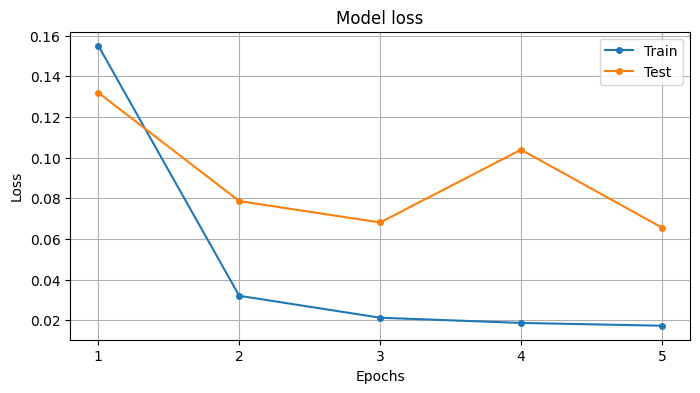

In [28]:
loss_mtgnn = train(MTGNN, data, num_nodes, batch_size, epochs, lr, opt, weight_decay,
                 L1Loss, step_size, num_split, clip, progress_train, verbose_train, 
                 verbose_train_epoch, save_path_model)

display_losses(loss_mtgnn)

In [29]:
_ = evaluate_model(data, save_path_model, batch_size)

Final test rse 0.0511 | test rae 0.0479 | test corr 0.9621


### 5.2 MTGAN

In [30]:
save_path_model = './mtgan-exchange-3.pt'

  0%|          | 0/5 [00:00<?, ?it/s]

| end of epoch   1 | time: 100.82s | train_loss 0.1402 | valid loss (rse) 0.1426 | valid rae 0.1425 | valid corr  0.8610
| end of epoch   2 | time: 100.69s | train_loss 0.0379 | valid loss (rse) 0.1619 | valid rae 0.1658 | valid corr  0.8788
| end of epoch   3 | time: 101.53s | train_loss 0.0304 | valid loss (rse) 0.1114 | valid rae 0.1043 | valid corr  0.8981
| end of epoch   4 | time: 100.57s | train_loss 0.0269 | valid loss (rse) 0.0994 | valid rae 0.0930 | valid corr  0.9122
| end of epoch   5 | time: 100.81s | train_loss 0.0240 | valid loss (rse) 0.1310 | valid rae 0.1346 | valid corr  0.9254
test rse 0.1310 | test rae 0.1346 | test corr 0.9254


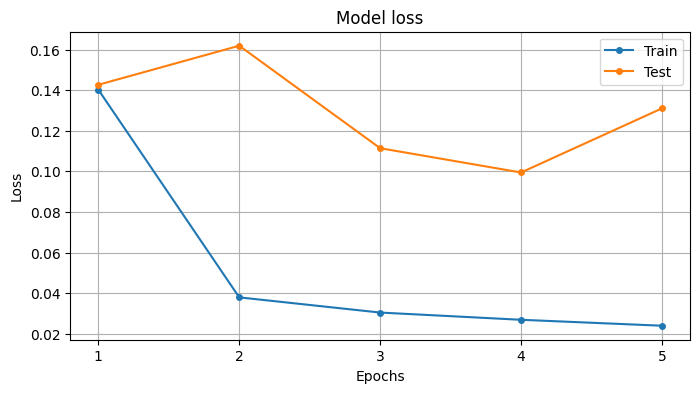

In [31]:
loss_mtgan = train(MTGAN, data, num_nodes, batch_size, epochs, lr, opt, weight_decay,
                 L1Loss, step_size, num_split, clip, progress_train, verbose_train, 
                 verbose_train_epoch, save_path_model)

display_losses(loss_mtgan)

In [32]:
_ = evaluate_model(data, save_path_model, batch_size)

Final test rse 0.1045 | test rae 0.1078 | test corr 0.9441


### 5.3 MTGNNAH

In [33]:
save_path_model = './mtgnnah-exchange-3.pt'

  0%|          | 0/5 [00:00<?, ?it/s]

| end of epoch   1 | time: 67.99s | train_loss 0.1212 | valid loss (rse) 0.1125 | valid rae 0.1099 | valid corr  0.9020
| end of epoch   2 | time: 67.87s | train_loss 0.0303 | valid loss (rse) 0.0686 | valid rae 0.0518 | valid corr  0.9477
| end of epoch   3 | time: 68.25s | train_loss 0.0199 | valid loss (rse) 0.0542 | valid rae 0.0443 | valid corr  0.9647
| end of epoch   4 | time: 68.86s | train_loss 0.0179 | valid loss (rse) 0.0590 | valid rae 0.0551 | valid corr  0.9716
| end of epoch   5 | time: 68.20s | train_loss 0.0156 | valid loss (rse) 0.0466 | valid rae 0.0367 | valid corr  0.9739
test rse 0.0466 | test rae 0.0367 | test corr 0.9739


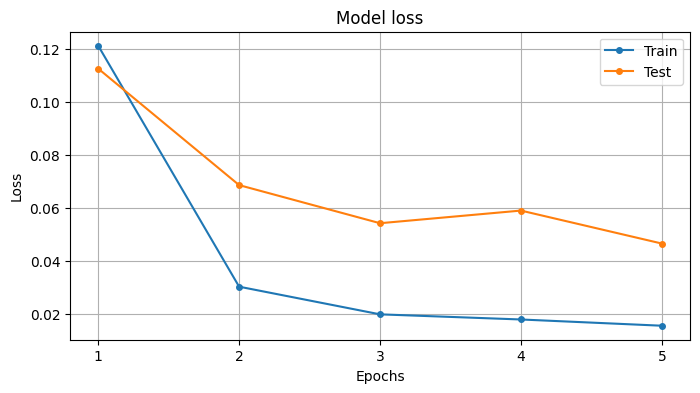

In [34]:
loss_mtgnnah = train(MTGNNAH, data, num_nodes, batch_size, epochs, lr, opt, weight_decay,
                 L1Loss, step_size, num_split, clip, progress_train, verbose_train, 
                 verbose_train_epoch, save_path_model)

display_losses(loss_mtgnnah)

In [35]:
_ = evaluate_model(data, save_path_model, batch_size)

Final test rse 0.0292 | test rae 0.0247 | test corr 0.9687


### 5.4 MTGANAH

In [36]:
save_path_model = './mtganah-exchange-3.pt'

  0%|          | 0/5 [00:00<?, ?it/s]

| end of epoch   1 | time: 104.15s | train_loss 0.1805 | valid loss (rse) 0.1404 | valid rae 0.1118 | valid corr  0.8614
| end of epoch   2 | time: 104.22s | train_loss 0.0459 | valid loss (rse) 0.1128 | valid rae 0.0852 | valid corr  0.8592
| end of epoch   3 | time: 105.81s | train_loss 0.0370 | valid loss (rse) 0.1043 | valid rae 0.0875 | valid corr  0.8743
| end of epoch   4 | time: 104.63s | train_loss 0.0338 | valid loss (rse) 0.1842 | valid rae 0.1672 | valid corr  0.8818
| end of epoch   5 | time: 104.64s | train_loss 0.0318 | valid loss (rse) 0.1730 | valid rae 0.1583 | valid corr  0.8942
test rse 0.1730 | test rae 0.1583 | test corr 0.8942


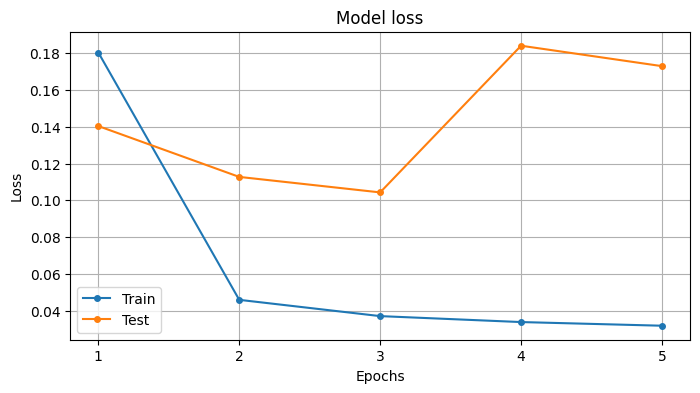

In [37]:
loss_mtganah = train(MTGANAH, data, num_nodes, batch_size, epochs, lr, opt, weight_decay,
                 L1Loss, step_size, num_split, clip, progress_train, verbose_train, 
                 verbose_train_epoch, save_path_model)

display_losses(loss_mtganah)

In [38]:
_ = evaluate_model(data, save_path_model, batch_size)

Final test rse 0.1649 | test rae 0.1750 | test corr 0.9284
